<a href="https://colab.research.google.com/github/xelothi/C-RAF_chemical_analysis/blob/main/clustering_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! pip install mols2grid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, rdFingerprintGenerator, AllChem, MACCSkeys
import numpy as np
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
import mols2grid
from IPython.display import display
from rdkit.Chem.rdFMCS import FindMCS
from tqdm import tqdm

In [5]:
df = pd.read_csv("CRAF_cleaned_and_preprocessed_data.csv", index_col=[0])
df

,molecule_chembl_id,std_smiles,MW,LogP,NumHDonors,NumHAcceptors,numRotatingBonds,norm_value,pIC50,bioactivity
0,CHEMBL18754,CNC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,345.468,4.35762,3.0,3.0,3.0,4900.00,5.309804,active
1,CHEMBL279560,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(O)cc1,348.424,4.18180,3.0,5.0,3.0,15000.00,4.823909,active
2,CHEMBL95114,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccn(C(C)C)n1,364.471,4.25360,2.0,6.0,4.0,16000.00,4.795880,active
3,CHEMBL279377,COC(=O)c1sc(C(C)(C)C)cc1NC(=O)Nc1ccc(C)cc1,346.452,4.78462,2.0,4.0,3.0,1700.00,5.769551,active
4,CHEMBL95692,COc1nccc(-c2c(-c3ccc(F)cc3)ncn2C2CCNCC2)n1,353.401,3.07930,1.0,6.0,4.0,50.00,7.301030,inactive
...,...,...,...,...,...,...,...,...,...,...
1699,CHEMBL5088891,CC1(C)CN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34...,485.595,2.56590,3.0,9.0,6.0,4.26,8.370590,inactive
1700,CHEMBL5079413,CN1CCCN(CCNc2nccc(-c3c(-c4cccc(O)c4)nc4sccn34)...,485.595,2.51960,2.0,9.0,6.0,1.96,8.707744,inactive
1701,CHEMBL5076688,O=S1(=O)NCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3sc...,457.541,1.78730,3.0,9.0,6.0,6.32,8.199283,inactive
1702,CHEMBL5079502,O=S1(=O)NCCCN1CCNc1nccc(-c2c(-c3cccc(O)c3)nc3s...,471.568,2.17740,3.0,9.0,6.0,7.21,8.142065,inactive


#Calculating the number of bits that should be used

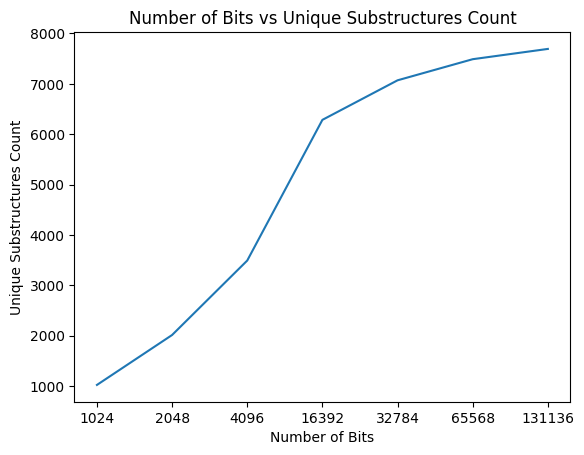

In [6]:
num_of_bits = [1024, 2048, 4096, 16392, 32784,65568,131136]
mols = [Chem.MolFromSmiles(smiles) for smiles in df['std_smiles']]  # Convert SMILES strings to RDKit molecules  # Assuming 'std_smiles' is the column name containing the SMILES strings
uniques = []

for bit in num_of_bits:
    FPs = []
    infos = []
    for mol in mols:
        info = {}
        FPs.append(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=bit, bitInfo=info, useFeatures=True))
        infos.append(info)
    uniques.append(np.logical_or.reduce(FPs).sum())

fig, ax = plt.subplots()
ax.plot(uniques)

# Set custom tick labels on the X-axis
plt.xticks(range(len(num_of_bits)), num_of_bits)

ax.yaxis.get_major_locator().set_params(integer=True)
plt.xlabel("Number of Bits")
plt.ylabel("Unique Substructures Count")
plt.title("Number of Bits vs Unique Substructures Count")

plt.show()

In [7]:
uniques

[1024, 2015, 3493, 6285, 7070, 7489, 7693]

# Butina clustering

RDKit fingeprints butina clustering

In [8]:
mols = []
for _, chembl_id, smiles in df[["molecule_chembl_id", "std_smiles"]].itertuples():
    mols.append((Chem.MolFromSmiles(smiles), chembl_id))
RDKFingerprints = []
MorganFingerprints = []
MACCS = []
for m,id in mols:
    RDKFingerprints.append(Chem.RDKFingerprint(m, maxPath=5))
    MorganFingerprints.append(AllChem.GetMorganFingerprintAsBitVect(m, 3, nBits=32784, bitInfo=info, useFeatures=True))
    MACCS.append(MACCSkeys.GenMACCSKeys(m))

Tanimoto similarity distance matrix 

In [9]:
# generate distance matrix using tanimoto
def tan_distance_matrix(fp):
  dist_matrix = []
  num_fps = len(fp)
  for i in range(1, num_fps):
    similarities = DataStructs.BulkTanimotoSimilarity(fp[i], fp[:i])
    dist_matrix.extend([1 - x for x in similarities])
  return dist_matrix
  

Dice similarity distance matrix

In [10]:
# generate distance matrix using Dice similarity
def dice_distance_matrix(fp):
  dist_matrix = []
  num_fps = len(fp)
  for i in range(1, num_fps):
    similarities = DataStructs.BulkDiceSimilarity(fp[i], fp[:i])
    dist_matrix.extend([1 - x for x in similarities])
  return dist_matrix


In [11]:
# cluster
def cluster(fp,dist_matrix, cutoff):
  num_fps = len(fp)
  clusters = Butina.ClusterData(dist_matrix, num_fps, cutoff, isDistData=True)
  return clusters

 Chosing the cutoff value for butina clustering

Calculating tanimoto distance matrix for all of our fingerprints

In [12]:
RDKFingerprints_tan_dist_matrix = tan_distance_matrix(RDKFingerprints)
MorganFingerprints_tan_dist_matrix = tan_distance_matrix(MorganFingerprints)
MACCS_dist_tan_matrix = tan_distance_matrix(MACCS)

Butina clustering using tanimoto distance matrix

In [13]:
RDKFingerprints_tan_cluster = cluster(RDKFingerprints, RDKFingerprints_tan_dist_matrix, cutoff=0.2)
MorganFingerprints_tan_cluster = cluster(MorganFingerprints, MorganFingerprints_tan_dist_matrix, 0.2)
MACCS_tan_cluster = cluster(MACCS, MACCS_dist_tan_matrix,0.2)

Butina clustering for dice distance matrix

In [14]:
RDKFingerprints_dice_dist_matrix = dice_distance_matrix(RDKFingerprints)
MorganFingerprints_dice_dist_matrix = dice_distance_matrix(MorganFingerprints)
MACCS_dice_dist_matrix = dice_distance_matrix(MACCS)

In [15]:
RDKFingerprints_dice_cluster = cluster(RDKFingerprints, RDKFingerprints_dice_dist_matrix, cutoff=0.2)
MorganFingerprints_dice_cluster = cluster(MorganFingerprints, MorganFingerprints_dice_dist_matrix, cutoff=0.2)
MACCS_dice_cluster = cluster(MACCS, MACCS_dice_dist_matrix, cutoff=0.2)

In [16]:
  def plot_clusters(fingerprints, dist_matrix, cutoff_range=(0.0, 1.0, 0.1)):
    for cutoff in np.arange(*cutoff_range):
        clusters = cluster(fingerprints, dist_matrix, cutoff)
        fig, ax = plt.subplots(figsize=(15, 4))
        ax.set_title(f"Threshold: {cutoff:3.1f}")
        ax.set_xlabel("Cluster index")
        ax.set_ylabel("Number of molecules")
        ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
        plt.show()



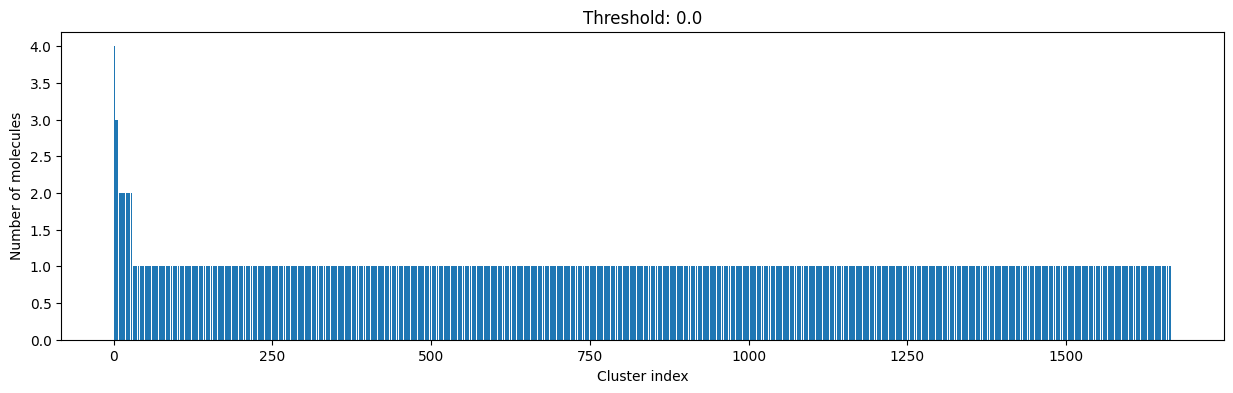

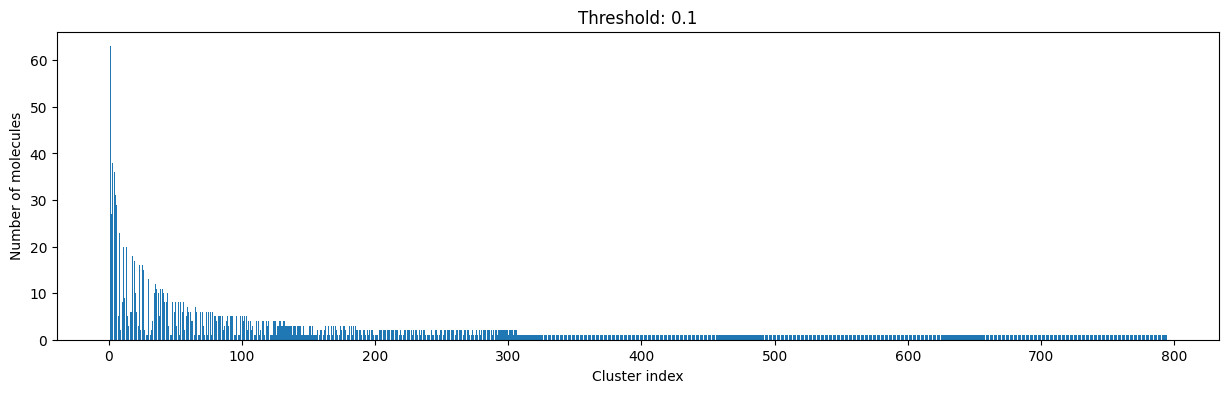

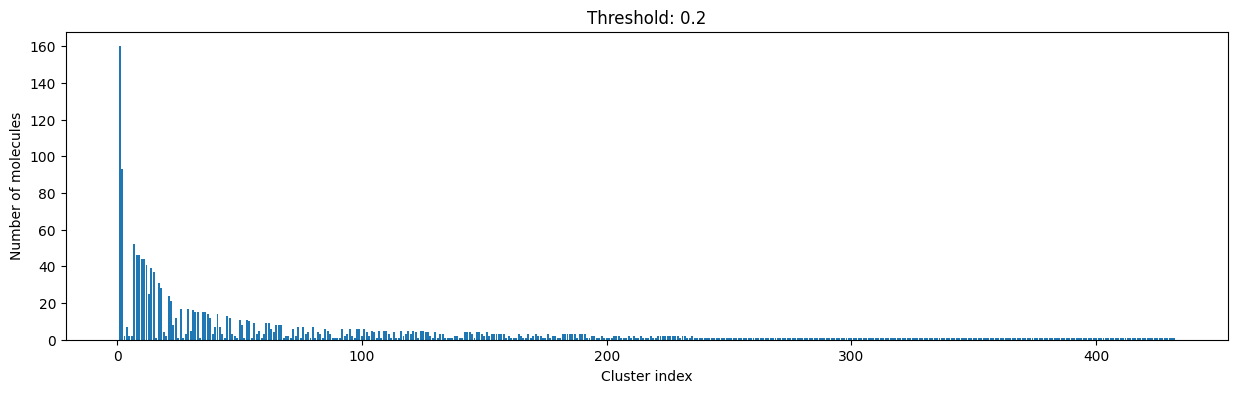

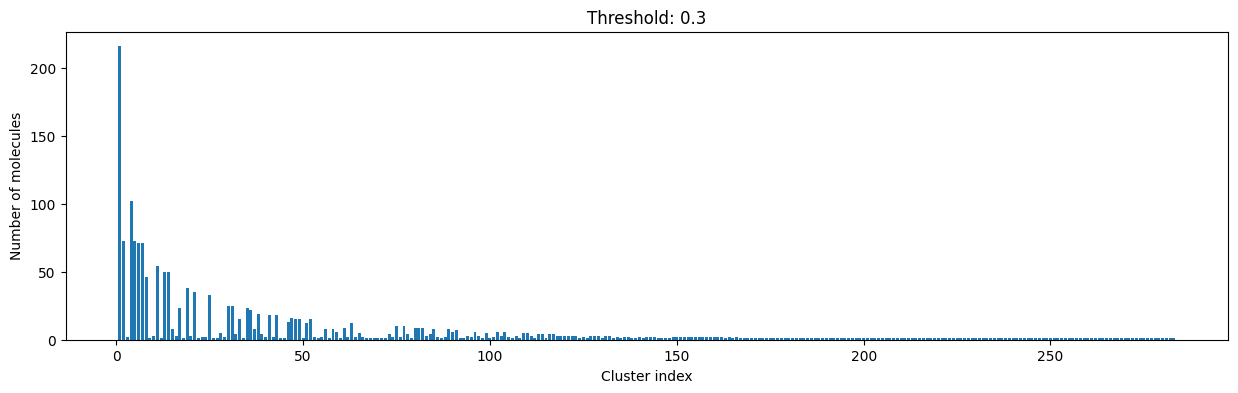

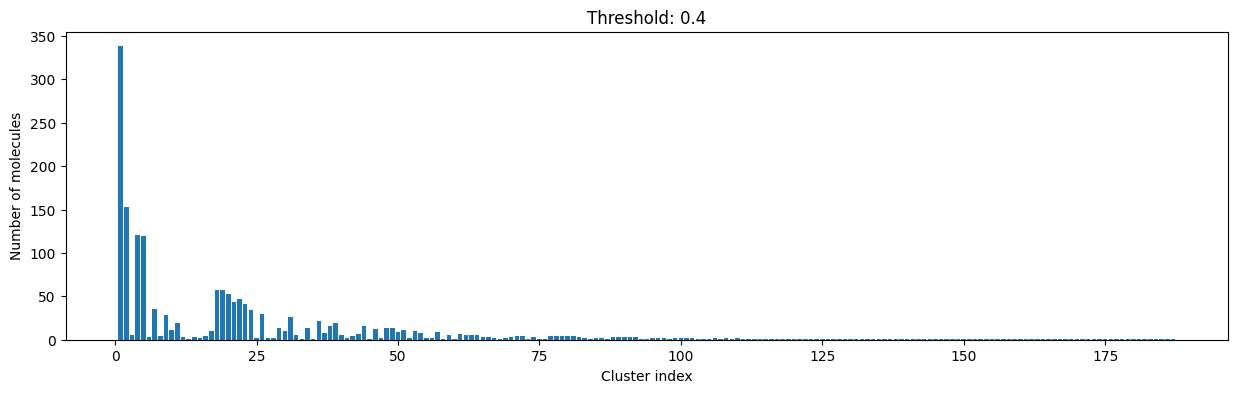

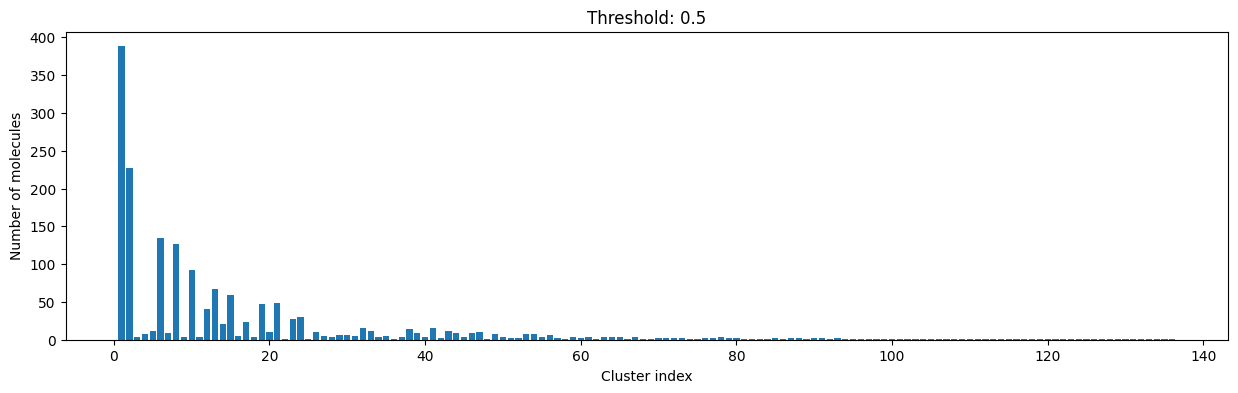

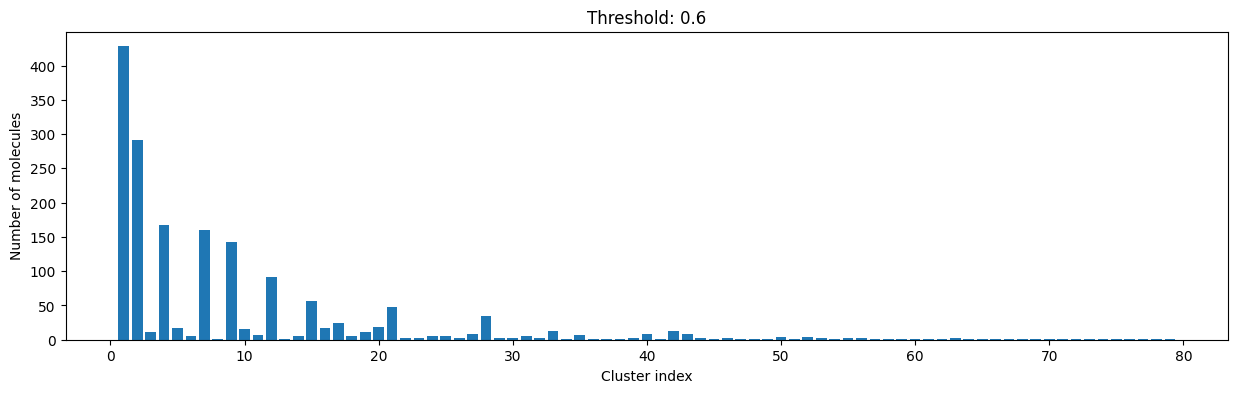

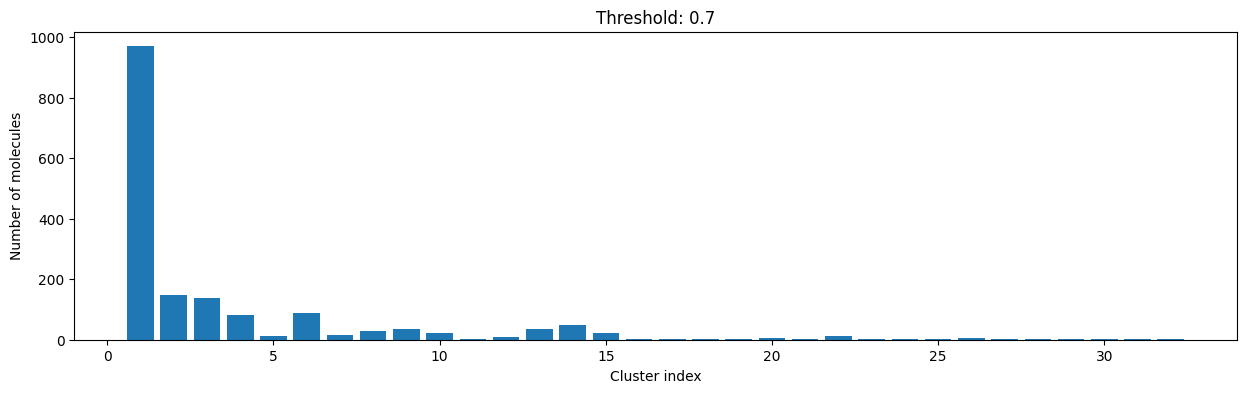

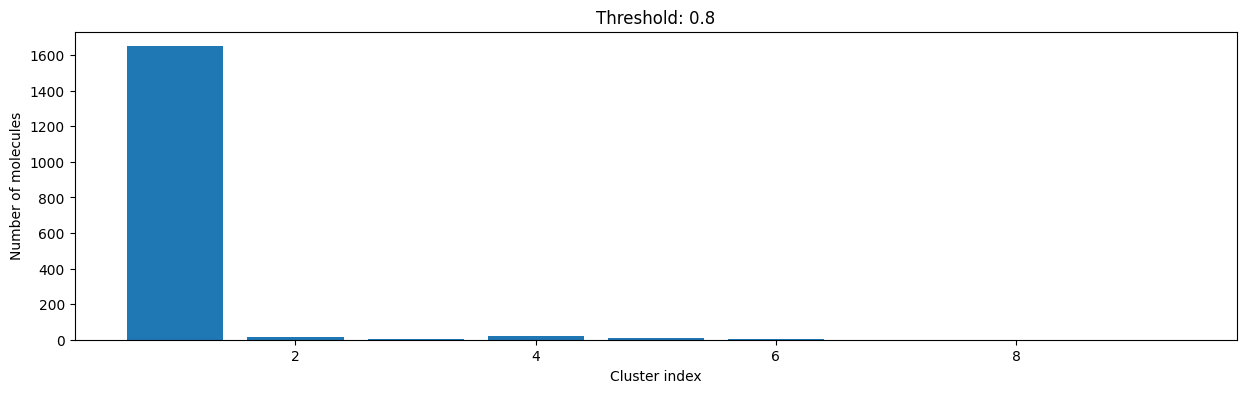

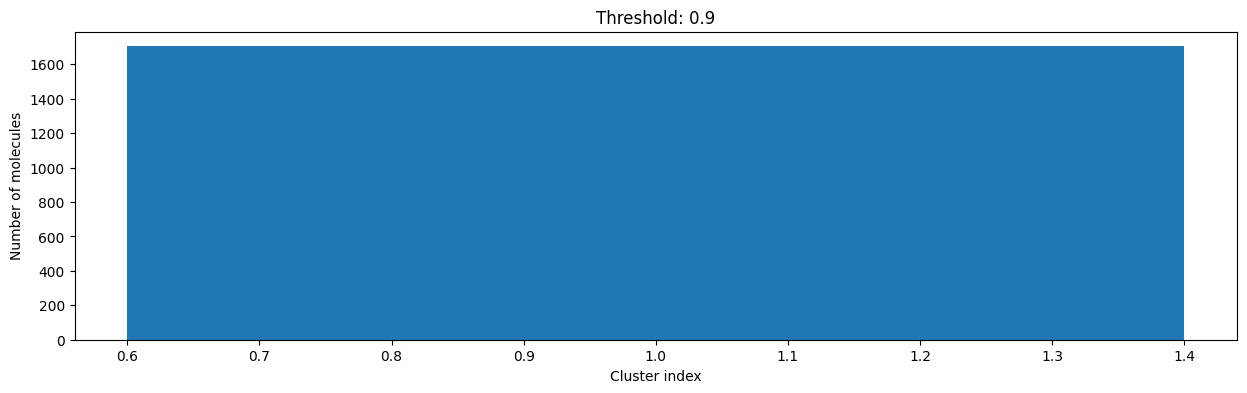

In [17]:
plot_clusters(RDKFingerprints, RDKFingerprints_tan_dist_matrix, cutoff_range=(0.0, 1.0, 0.1))

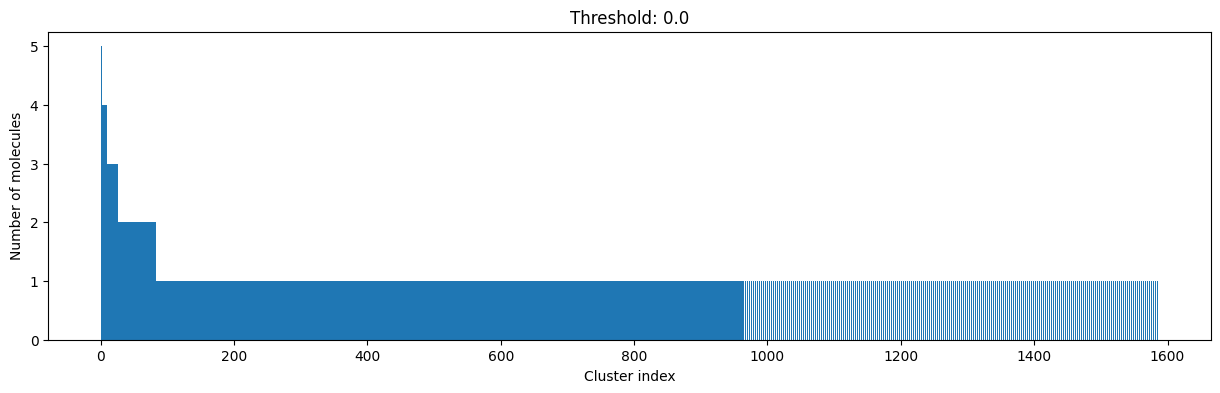

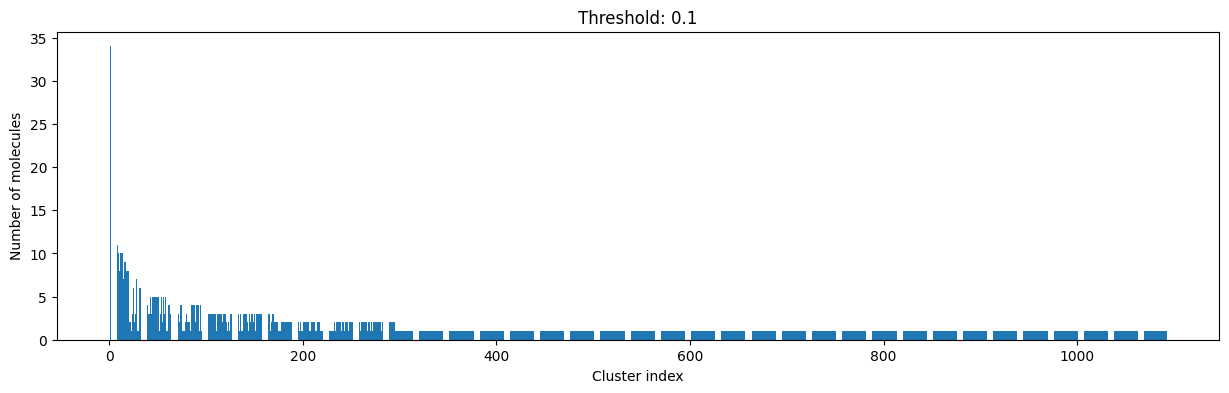

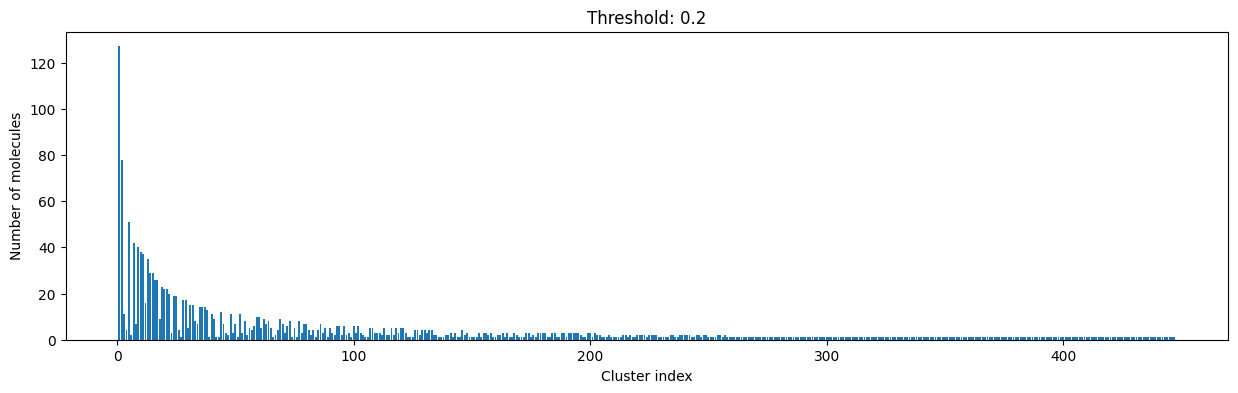

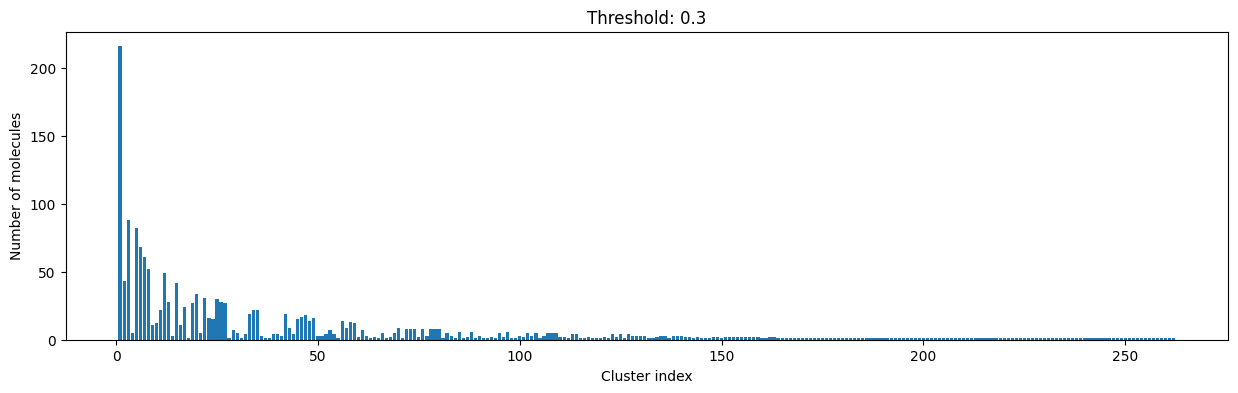

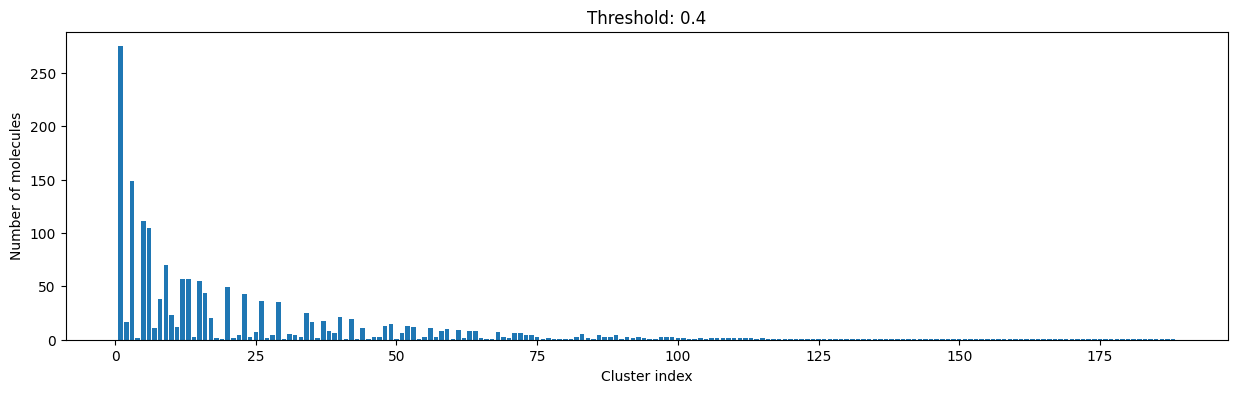

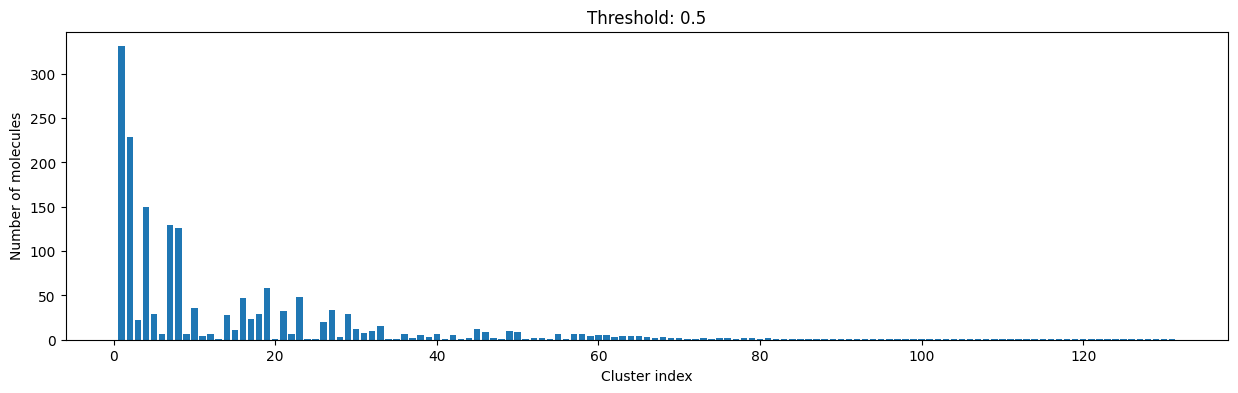

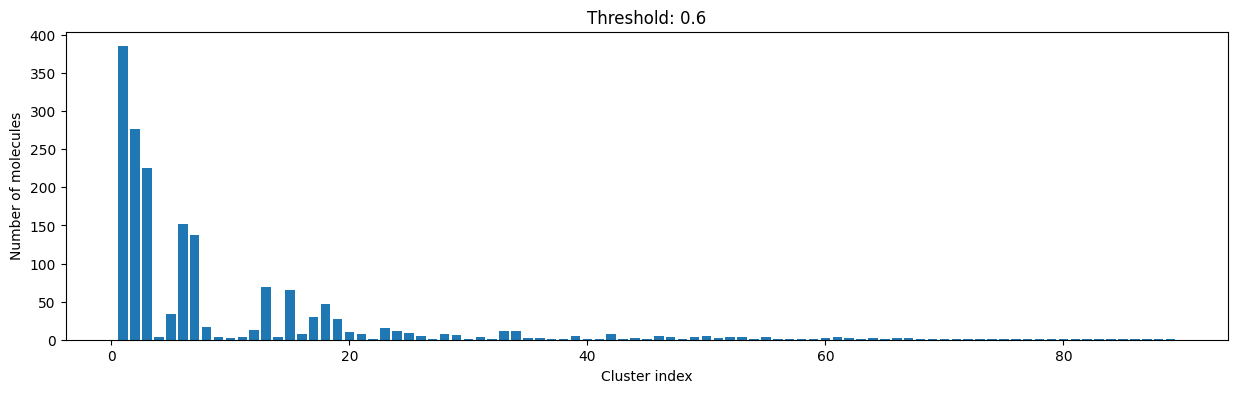

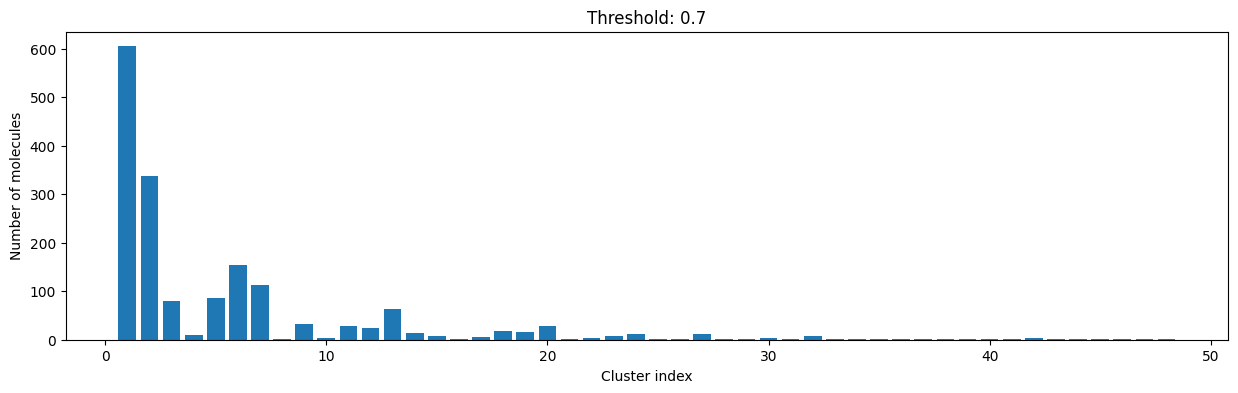

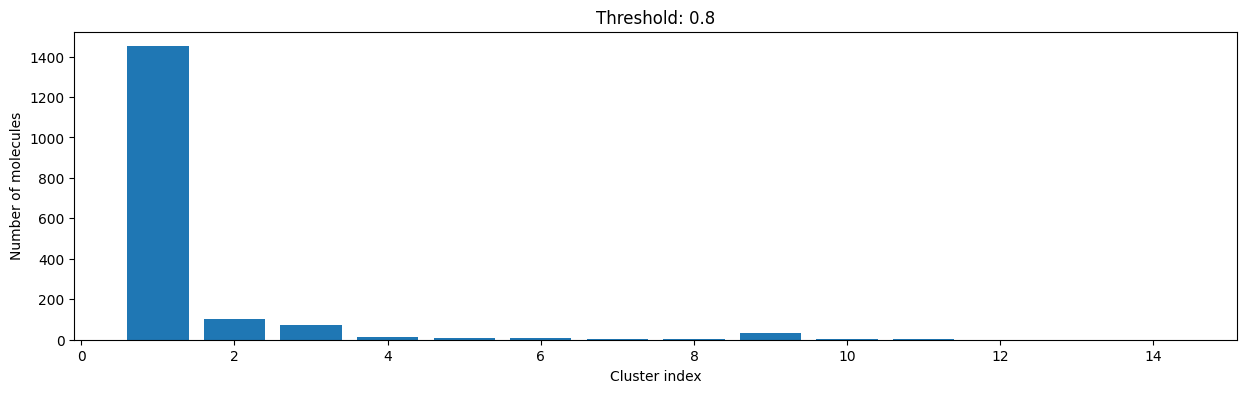

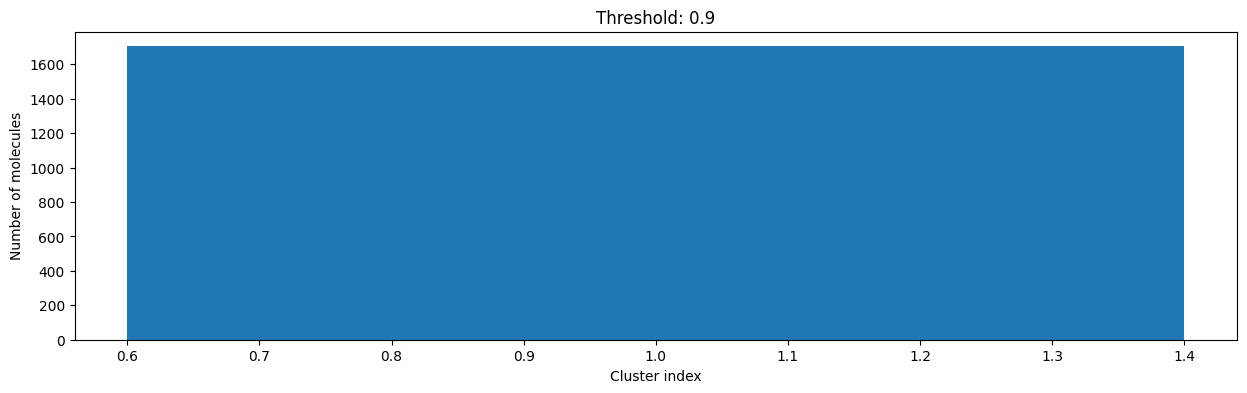

In [18]:
plot_clusters(MorganFingerprints, MorganFingerprints_dice_dist_matrix, cutoff_range=(0.0, 1.0, 0.1))

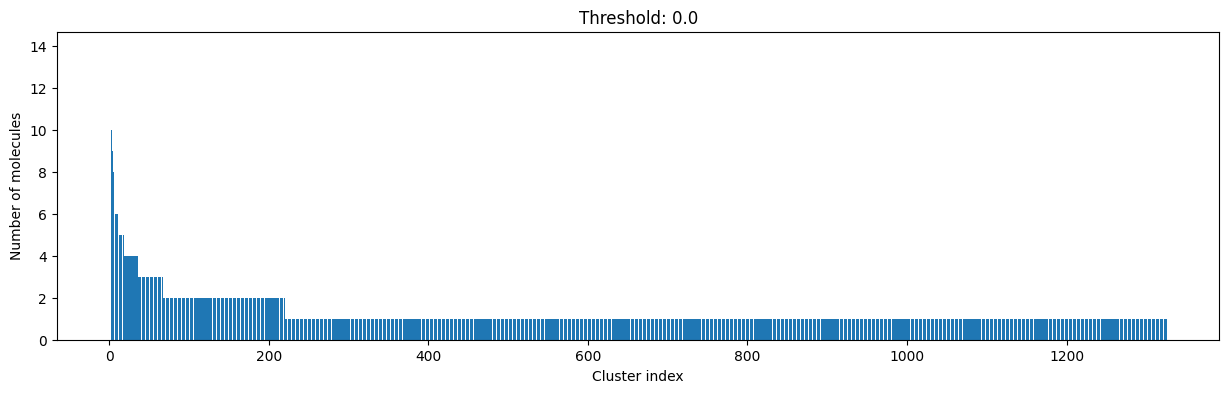

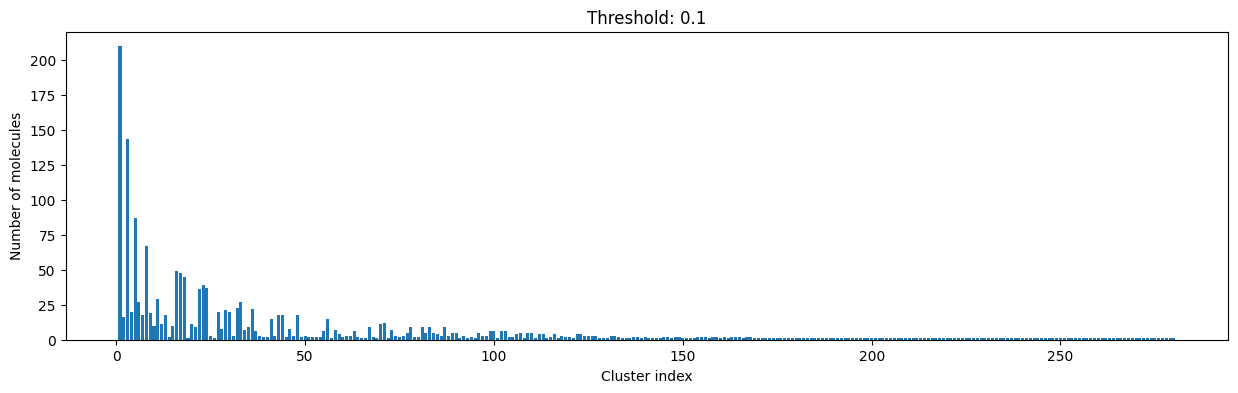

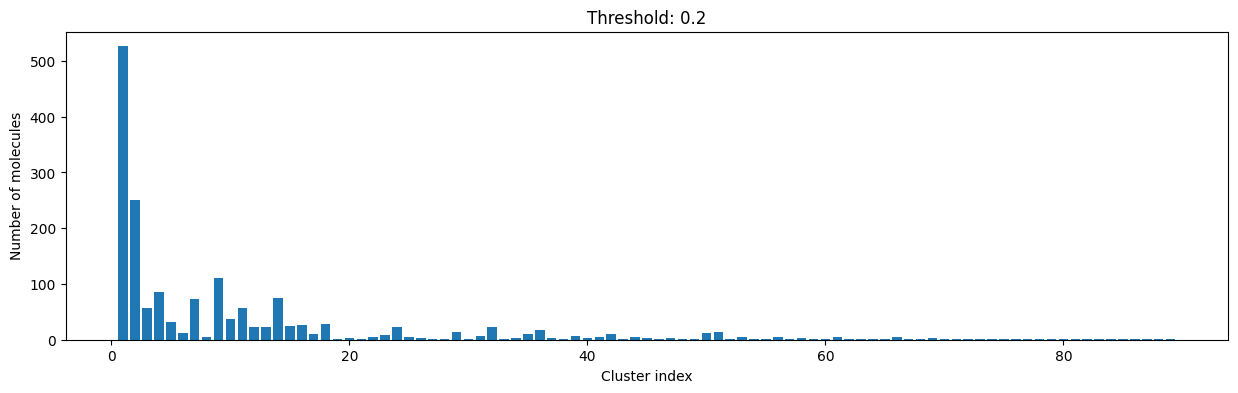

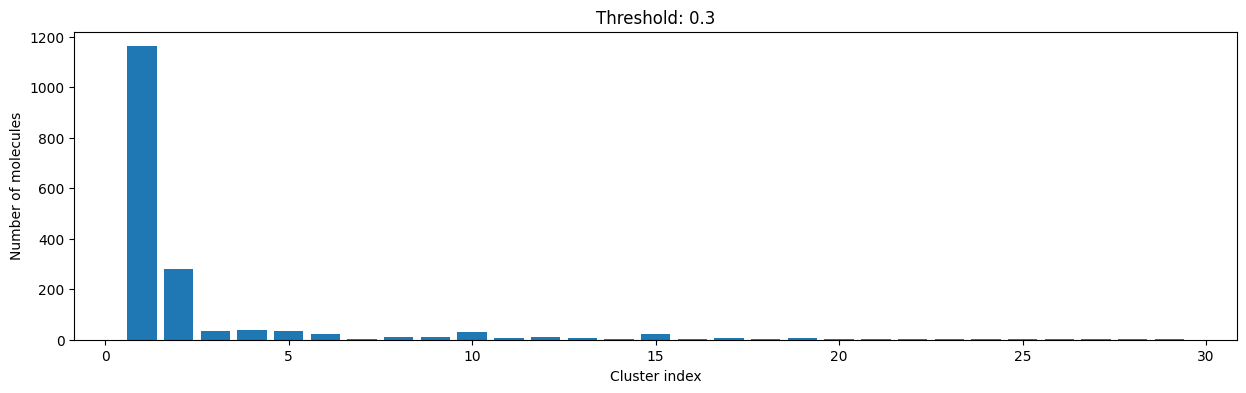

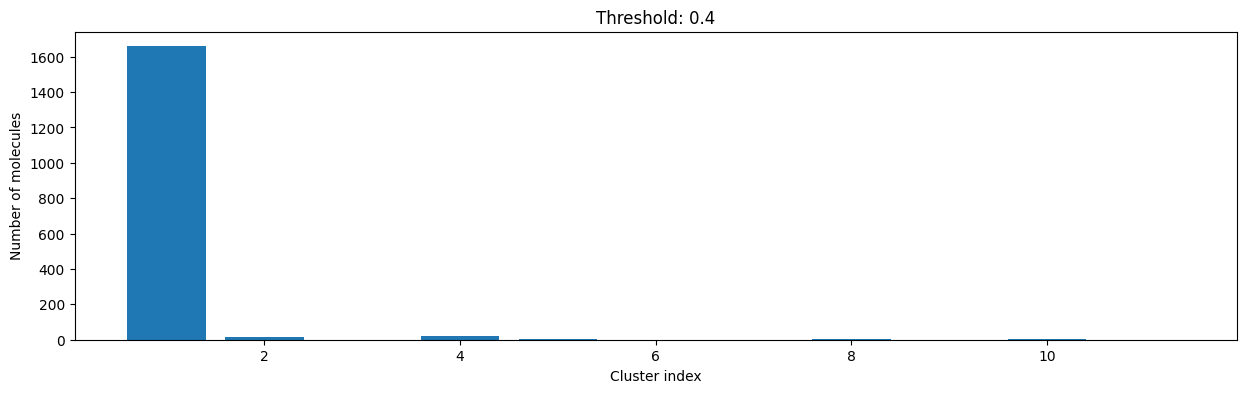

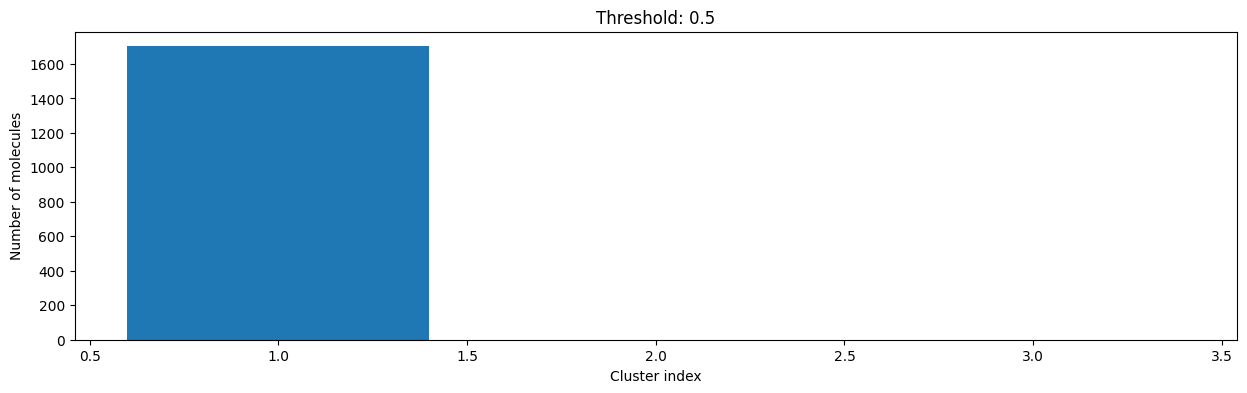

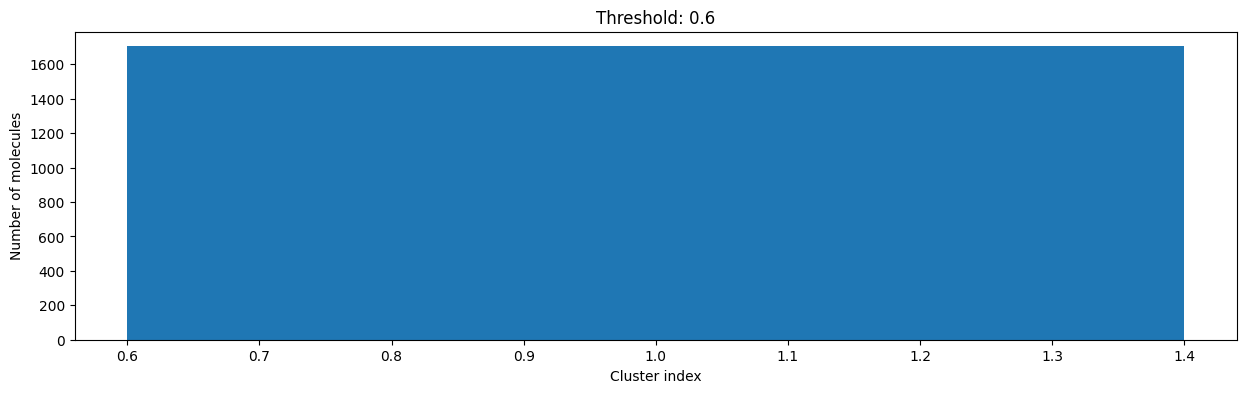

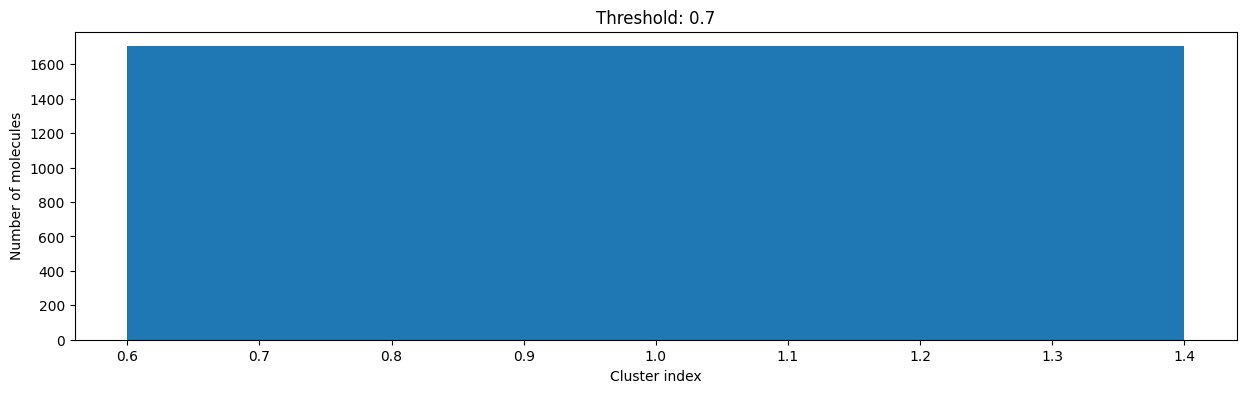

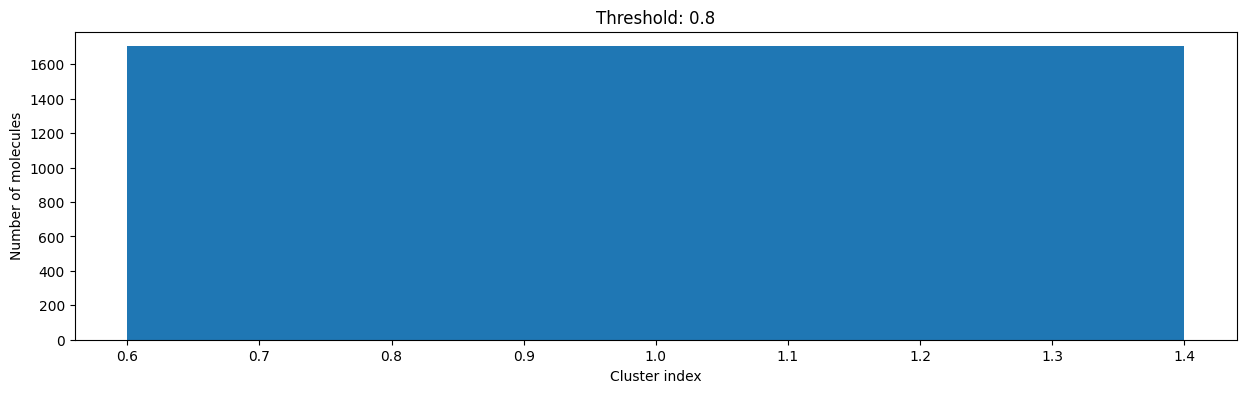

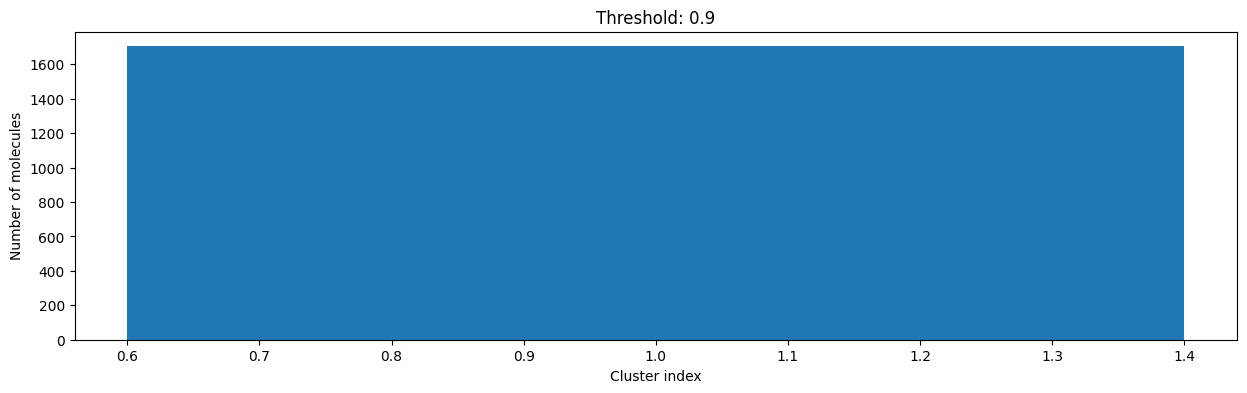

In [19]:
plot_clusters(MACCS, MACCS_dice_dist_matrix, cutoff_range=(0.0, 1.0, 0.1))

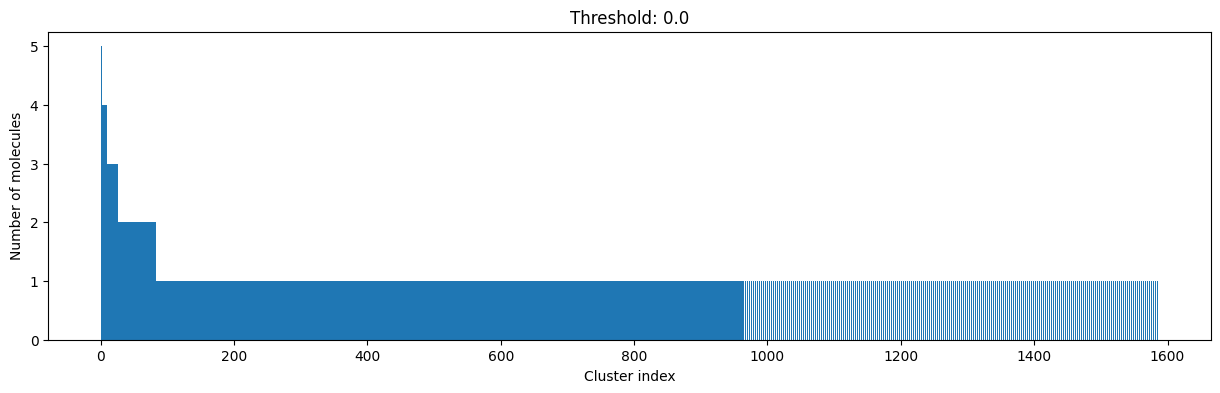

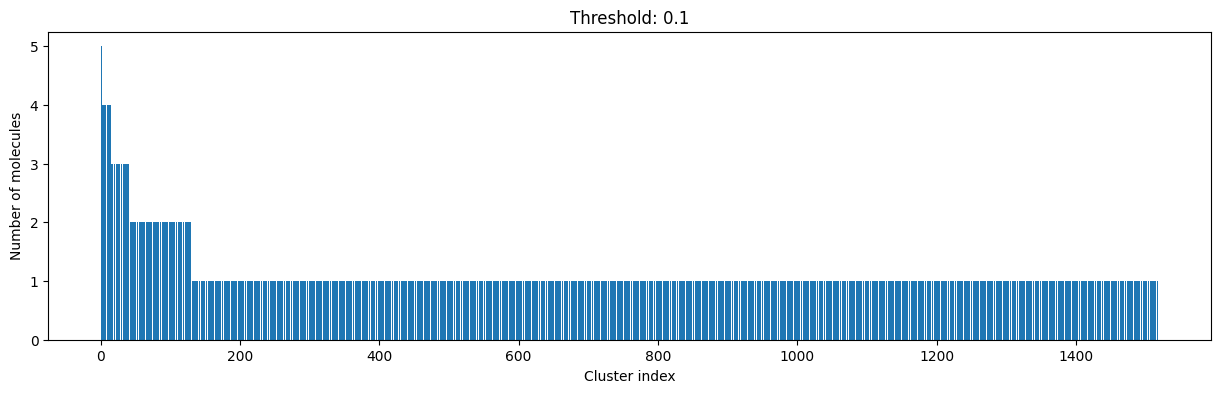

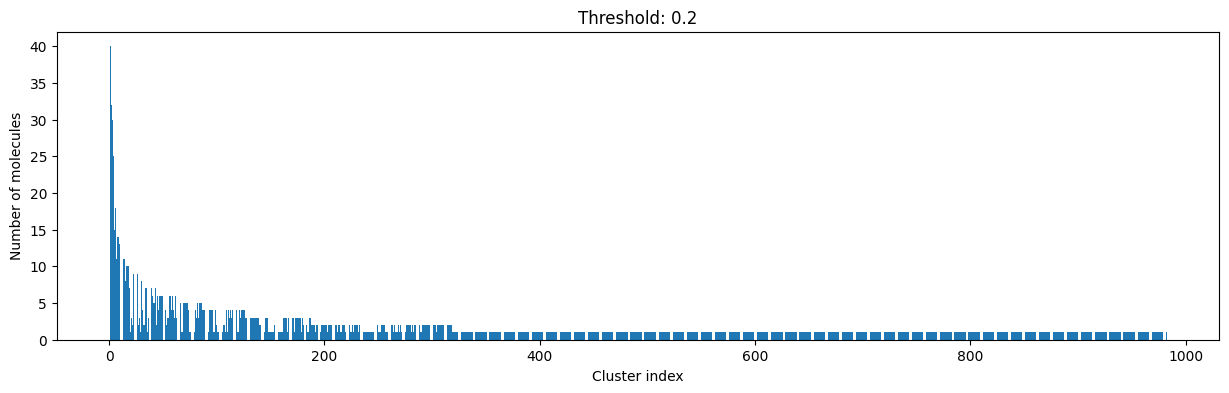

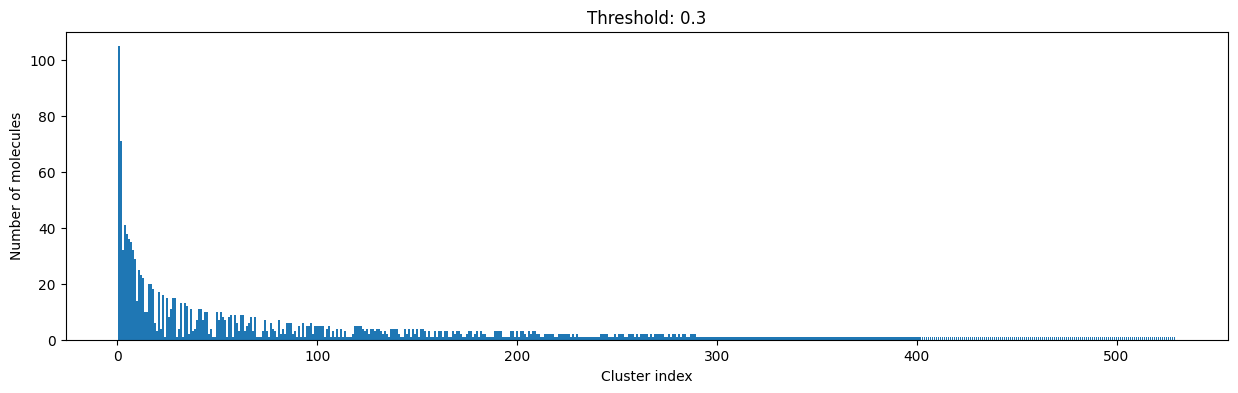

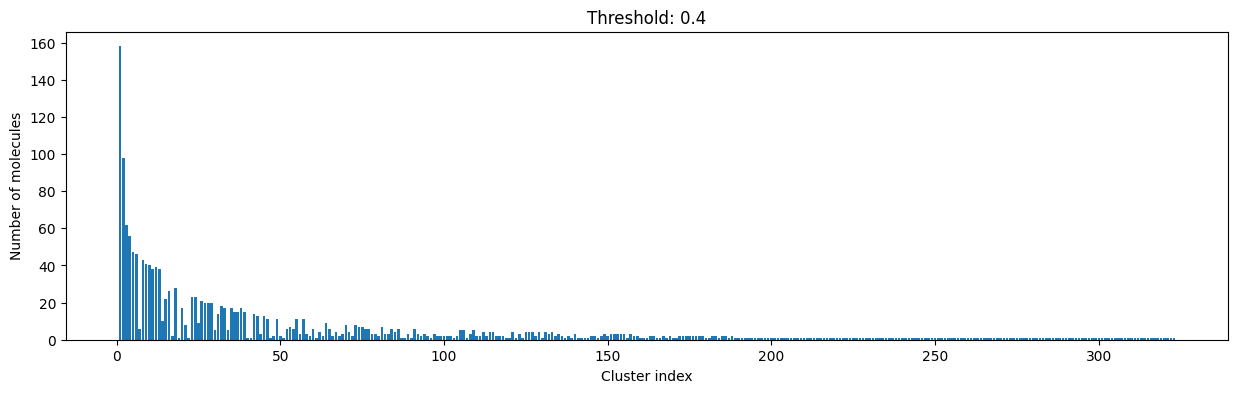

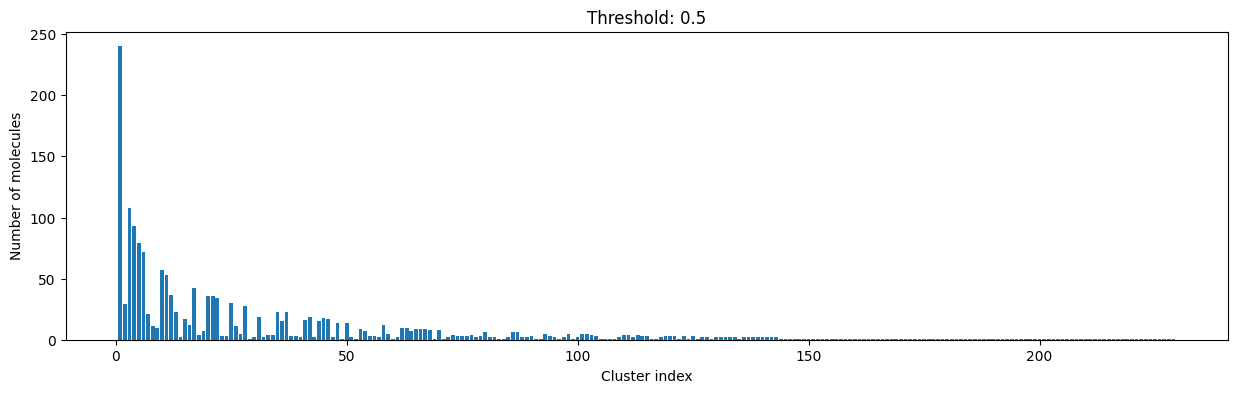

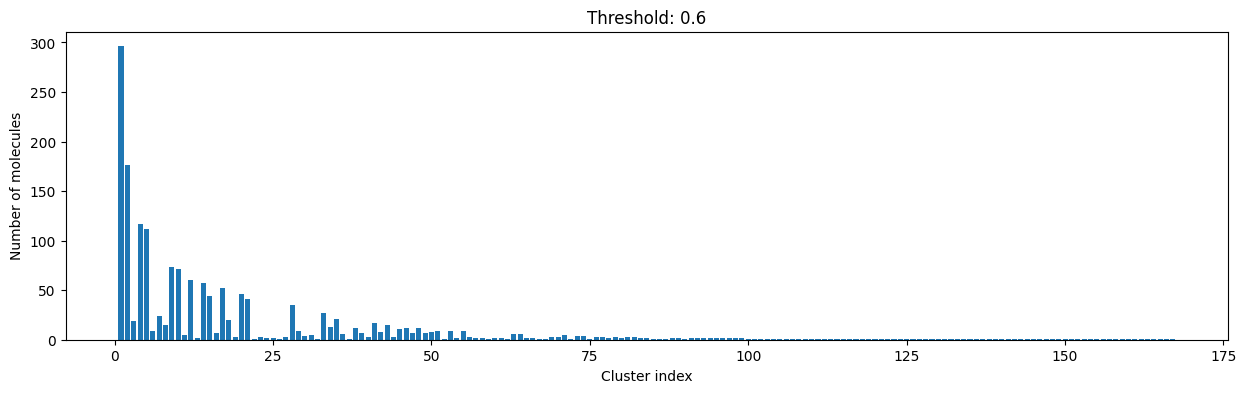

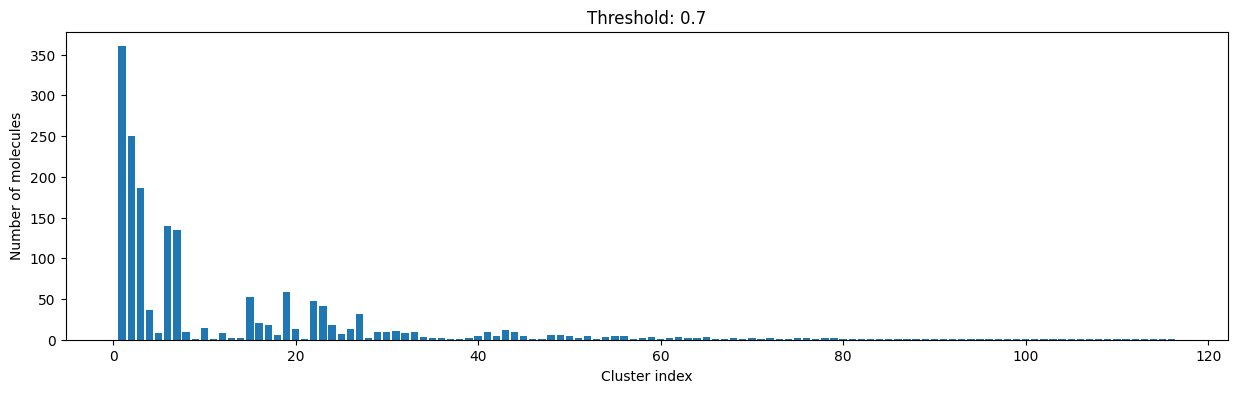

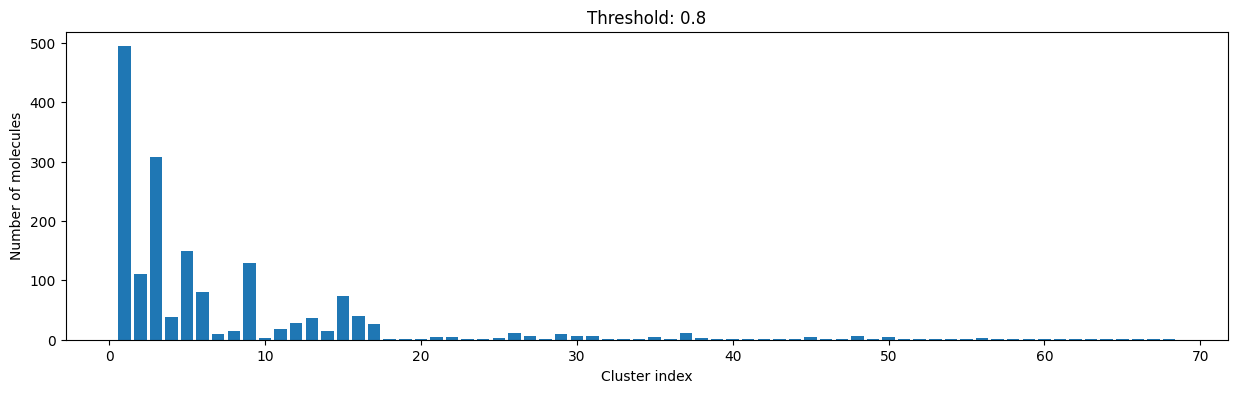

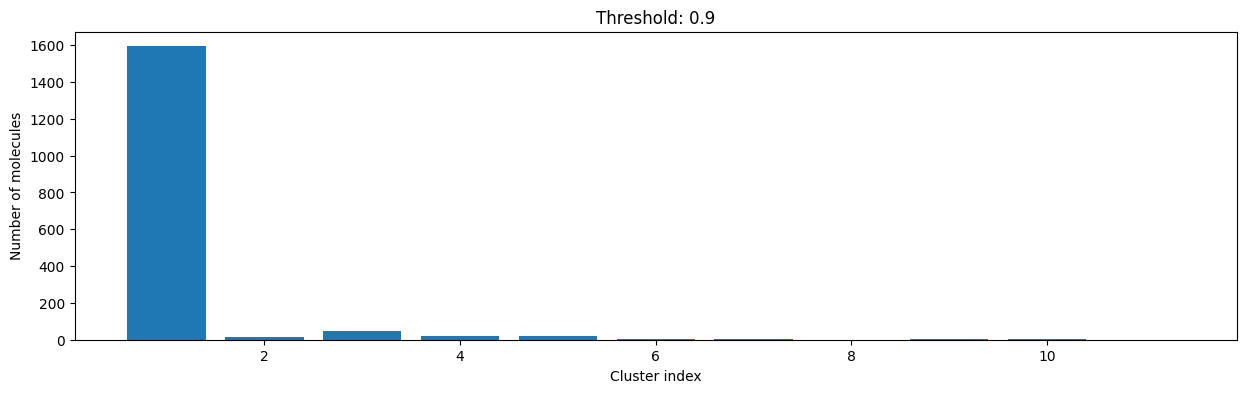

In [20]:
plot_clusters(MorganFingerprints, MorganFingerprints_tan_dist_matrix, cutoff_range=(0.0, 1.0, 0.1))

#Calculating Tanimoto distance of RDKFingerprints inside the clusters

In [21]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tan_distance_matrix(cluster)])
    return intra_similarity
    

In [26]:
mols = [(Chem.MolFromSmiles(smiles), chembl_id) for _, chembl_id, smiles in df[["molecule_chembl_id", "std_smiles"]].itertuples()]

mol_fps_per_cluster = []
for cluster in RDKFingerprints_tan_cluster[:10]:
    mol_fps = [Chem.RDKFingerprint(mol[i][0]) for i in cluster, maxPath=5) for mol, _ in mols]
    mol_fps_per_cluster.append(mol_fps)

intra_sim = intra_tanimoto(mol_fps_per_cluster)

Size of subset_intra_sim: 10
Subset intra_sim: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



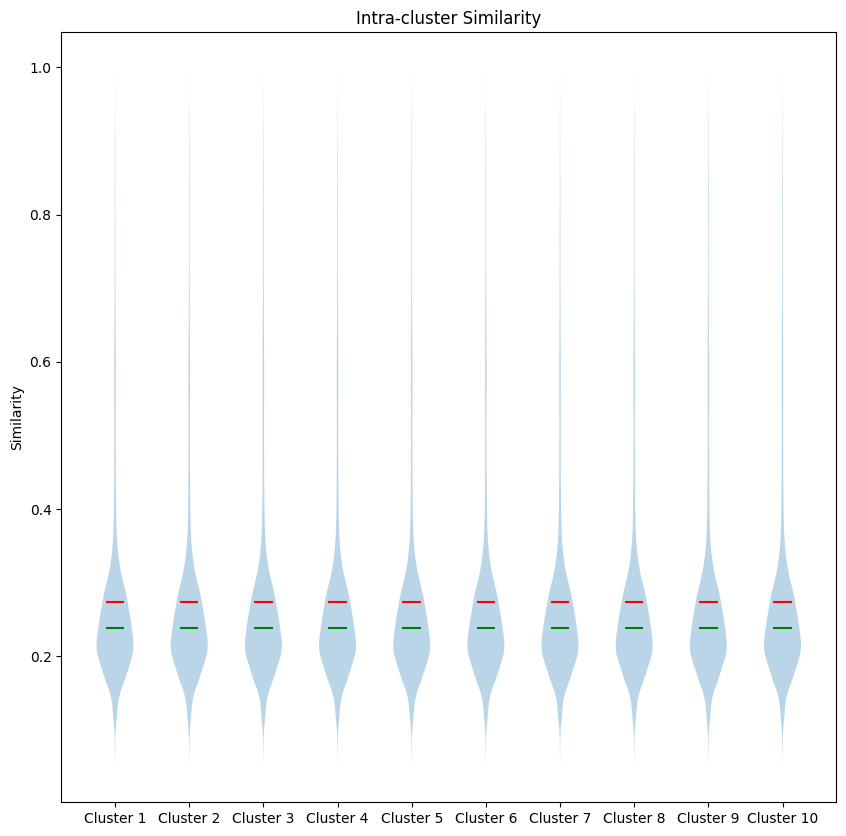

In [30]:
def plot_violin(data, labels):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title("Intra-cluster Similarity")
    ax.set_ylabel("Similarity")
    plot = ax.violinplot(data, showmedians=True, showmeans=True, showextrema=False)
    plot["cmeans"].set_color("red")
    plot["cmedians"].set_color("green")
    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    plt.show()


subset_intra_sim = intra_sim[:10]
print("Size of subset_intra_sim:", len(subset_intra_sim))
print("Subset intra_sim:", subset_intra_sim)

# Generate labels for the violin plot
labels = [f"Cluster {i+1}" for i in range(len(subset_intra_sim))]
print("Labels:", labels)

# Plot the violin plot
plot_violin(subset_intra_sim, labels)


Drawing the 12 top molecules in clusters

In [45]:
def draw(molecules):
    molecules = molecules.MolFromSmiles()
    legends = [f"Molecule {i+1}" for i in range(min(12, len(mols)))]
    return Draw.MolsToGridImage(mols[:12], legends=legends, molsPerRow=4)

# Assuming you have a list of SMILES strings stored in the variable 'molecules'
grid_image = draw(RDKFingerprints_tan_cluster)


TypeError: ignored

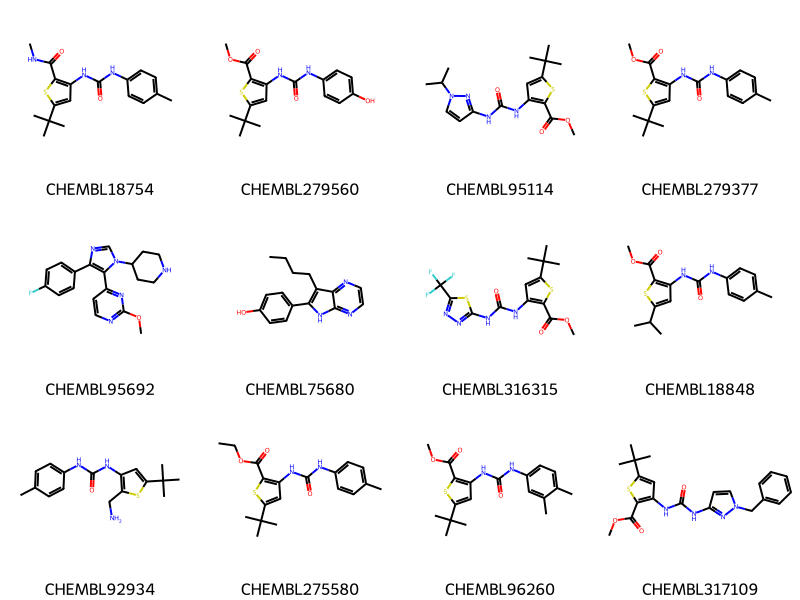

In [53]:
mols = [(Chem.MolFromSmiles(smiles), chembl_id) for _, chembl_id, smiles in df[["molecule_chembl_id", "std_smiles"]].itertuples()]
Draw.MolsToGridImage([mols[i][0] for i in range(min(12, len(mols)))], legends=[mols[i][1] for i in range(min(12, len(mols)))], molsPerRow=4)


# Maximum common substructure

In [35]:
def visualize_mcs(molecules, threshold=0.8):
    # Find the Maximum Common Substructure (MCS)
    mcs_result = FindMCS(molecules, threshold=threshold)

    # Get the MCS SMARTS string and create the MCS molecule
    mcs_smarts = mcs_result.smartsString
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)

    # Configure drawing options
    drawing_options = Draw.DrawingOptions()
    drawing_options.atomLabelFontSize = 18
    drawing_options.bondLineWidth = 2.0

    # Draw the MCS molecule
    image = Draw.MolToImage(mcs_mol, options=drawing_options)

    # Display the image
    image.show()


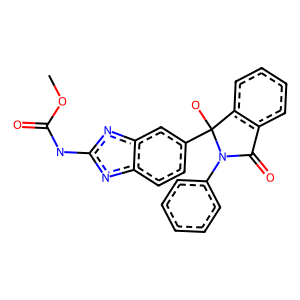

In [37]:
mols = [Chem.MolFromSmiles(smiles) for smiles in df['std_smiles']]
molecules = [mols[i] for i in RDKFingerprints_tan_cluster[0]]
visualize_mcs(molecules, threshold=0.8)